# Variational Inference Demo

Traditional neural network makes predictions given input data, but does not quantify prediction uncertainty.  
This notebook demonstrates how Bayesian Neural Networks (BNN) quantifies prediction uncertainty via variational inference. 

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

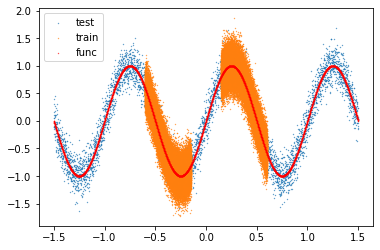

In [8]:
# make some data with noise
train_size = int(5e4)
test_size = int(5e3)

map_func = lambda x, noise: np.sin(2 * np.pi * (x)) + np.random.randn(*x.shape) * noise

X1_train = np.linspace(-0.6, -0.15, train_size).reshape(-1, 1)
X2_train = np.linspace(0.15, 0.6, train_size).reshape(-1, 1)
X_train = np.concatenate([X1_train, X2_train], 0)
np.random.shuffle(X_train)

y_train = map_func(X_train, 0.2)

X_test = np.linspace(-1.5, 1.5, test_size).reshape(-1, 1)
y_test = map_func(X_test, 0.2)

y_true = map_func(X_test, 0)
plt.scatter(X_test, y_test, s=0.1, label='test')
plt.scatter(X_train, y_train, s=0.1, label='train')
plt.scatter(X_test, y_true, s=0.1, c='r', label='func')
plt.legend()
plt.show()

In [9]:
# bnn model
kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / X_train.shape[0]
dense_v = lambda filters, atv: tfp.layers.DenseReparameterization(filters,
                                                                  activation = atv,
                                                                  kernel_divergence_fn=kernel_divergence_fn)
def create_model():
    inp = tf.keras.Input(shape=(1))
    
    x = dense_v(32, 'relu')(inp)
    x = dense_v(16, 'relu')(x)
    x = dense_v(1, 'linear')(x)
    
    model = tf.keras.Model(inp, x)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    return model 

model = create_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_reparameterization_3 ( (None, 32)                96        
_________________________________________________________________
dense_reparameterization_4 ( (None, 16)                1040      
_________________________________________________________________
dense_reparameterization_5 ( (None, 1)                 33        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [10]:
# train and validate
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)
model.fit(X_train, y_train,
          validation_split = 0.1,
          batch_size=256,
          epochs=100, 
          callbacks=[early_stopping_callback])

Epoch 1/100
352/352 [==============================] - 5s 13ms/step - loss: 0.4792 - mae: 0.5962 - val_loss: 0.2265 - val_mae: 0.3886
Epoch 2/100
352/352 [==============================] - 4s 12ms/step - loss: 0.1490 - mae: 0.2972 - val_loss: 0.0671 - val_mae: 0.1855
Epoch 3/100
352/352 [==============================] - 4s 12ms/step - loss: 0.0686 - mae: 0.1878 - val_loss: 0.0644 - val_mae: 0.1814
Epoch 4/100
352/352 [==============================] - 4s 12ms/step - loss: 0.0633 - mae: 0.1804 - val_loss: 0.0616 - val_mae: 0.1778
Epoch 5/100
352/352 [==============================] - 4s 12ms/step - loss: 0.0607 - mae: 0.1768 - val_loss: 0.0612 - val_mae: 0.1773
Epoch 6/100
352/352 [==============================] - 4s 12ms/step - loss: 0.0590 - mae: 0.1749 - val_loss: 0.0596 - val_mae: 0.1761
Epoch 7/100
352/352 [==============================] - 4s 12ms/step - loss: 0.0575 - mae: 0.1729 - val_loss: 0.0558 - val_mae: 0.1703
Epoch 8/100
352/352 [==============================] - 4s 12ms

In [85]:
# variational inference
y_pred = np.concatenate([model.predict(X_test) for j in tqdm(range(50))], -1)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.98it/s]


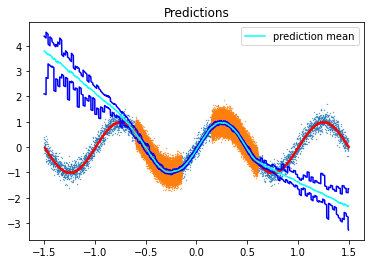

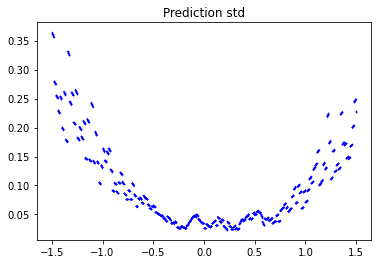

In [91]:
plt.scatter(X_test, y_test, s=0.1)
plt.scatter(X_train, y_train, s=0.1)
plt.scatter(X_test, y_true, s=0.1, c='r')

# prediction mean and boundaries vs. input X
plt.plot(X_test, np.max(y_pred, -1),c='b')    
plt.plot(X_test, np.min(y_pred, -1), c='b')      
plt.plot(X_test, np.mean(y_pred, -1), c='cyan', label='prediction mean')    
plt.title('Predictions')
plt.legend()
plt.show()

# prediction std (prediction uncertainty) vs.input X
y_pred_std = np.std(y_pred, -1)
plt.scatter(X_test, out_std, s = 0.1, c='b')
plt.title('Prediction std')
plt.show()